In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as stats

from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.model_selection import RepeatedStratifiedKFold

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
cwd = os.getcwd()
BASE_DIR = os.path.abspath(os.path.join(cwd, "..", ".."))

# build paths inside the repo
get_data_path = lambda folders, fname: os.path.normpath(
    os.path.join(BASE_DIR, *folders, fname)
)

file_path_training_data = get_data_path(['data', 'output', 'models'], 'training_data.csv')

figure_path_a = get_data_path(['figures'], '1a_gene_feature_barplot.png')
figure_path_b = get_data_path(['figures'], '1b_gene_feature_boxplot.png') 

figure_path_a2 = get_data_path(['figures'], '1a2_gene_feature_no_essentials_barplot.png')

In [3]:
# load dataframe
df = pd.read_csv(file_path_training_data)
df.head()

,genepair,A1,A2,A1_entrez,A2_entrez,DepMap_ID,cell_line,Gemini_FDR,raw_LFC,SL,...,colocalisation,interact,n_total_ppi,fet_ppi_overlap,gtex_spearman_corr,gtex_min_mean_expr,gtex_max_mean_expr,GEMINI,LFC,SL_new
0,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000022,PATU8988S_PANCREAS,0.998944,0.088856,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.118768,0.088856,False
1,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000307,PK1_PANCREAS,0.986587,0.201704,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.132501,0.201704,False
2,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000632,HS944T_SKIN,1.000000,0.069772,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.024593,0.069772,False
3,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000681,A549_LUNG,0.977988,0.379455,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,-0.241323,0.379455,False
4,A3GALT2_ABO,A3GALT2,ABO,127550.0,28.0,ACH-000756,GI1_CENTRAL_NERVOUS_SYSTEM,0.999586,-0.077118,False,...,0.0,False,3.0,0.0,0.114847,0.258739,11.702,0.299715,-0.077118,False


### Individual Feature Analysis: Predictive Power of Genomic Features
### Bar plot

Calculate the predictive power of individual genomics features such as gene expresion, essentiality etc.
 
The resulting visualization helps identify which features independently contribute most to the prediction of synthetic lethality.

In [ ]:
# Define feature metadata using a dictionary
features_dict = [
    {"name": "zMaxExp_A1A2", "label": "Gene zExpression (max)", "category": "expression"},
    {"name": "zMinExp_A1A2", "label": "Gene zExpression (min)", "category": "expression"},
    {"name": "rMaxExp_A1A2", "label": "Gene Expression (max)", "category": "expression"},
    {"name": "rMinExp_A1A2", "label": "Gene Expression (min)", "category": "expression"},
    {"name": "z_max_ranked_A1A2", "label": "Gene zEssentiality (max)", "category": "essentiality"},
    {"name": "z_min_ranked_A1A2", "label": "Gene zEssentiality (min)", "category": "essentiality"},
    {"name": "max_ranked_A1A2", "label": "Gene Essentiality (max)", "category": "essentiality"},
    {"name": "min_ranked_A1A2", "label": "Gene Essentiality (min)", "category": "essentiality"},
    {"name": "max_cn", "label": "Copy Number (max)", "category": "genomic"},
    {"name": "min_cn", "label": "Copy Number (min)", "category": "genomic"},
    {"name": "Protein_Altering", "label": "Protein Altering Mutation", "category": "genomic"},
    {"name": "Damaging", "label": "Damaging Mutation", "category": "genomic"},
    {"name": "min_sequence_identity", "label": "Sequence Identity", "category": "sequence"}
]

# Extract specific information dynamically if needed
feature_columns = [f["name"] for f in features_dict]
labels = [f["label"] for f in features_dict]
categories = [f["category"] for f in features_dict]

# Target column
target_column = "SL_new"


In [18]:
def calculate_predictive_power(df, feature_columns, target_column, labels, categories):
    data, target = df[feature_columns], df[target_column].values

    n_folds = 5
    n_repeats = 10
    rskf = RepeatedStratifiedKFold(n_splits=n_folds, n_repeats=n_repeats, random_state=42)

    mean_aucs = []
    mean_prs = []

    pos_directions = []
    neg_directions = []

    baseline_pr_auc = np.sum(target) / len(target)
    print(f'Baseline PR AUC: {baseline_pr_auc:.4f}')

    for feature_name in feature_columns:
        feature_raw = data[feature_name]

        # Remove NaNs — mask for non-NaN entries
        valid_mask = ~feature_raw.isna()
        feature = feature_raw[valid_mask].values
        target_clean = target[valid_mask]

        # Skip feature if there's not enough data left
        if len(feature) < 2 or len(np.unique(target_clean)) < 2:
            print(f'Skipping feature {feature_name}: insufficient data after removing NaNs.')
            mean_aucs.append(np.nan)
            mean_prs.append(np.nan)
            continue

        # Flip direction if needed
        pos_direction = roc_auc_score(target_clean, feature)
        neg_direction = roc_auc_score(target_clean, -feature)

        pos_directions.append(pos_direction)
        neg_directions.append(neg_direction)

        if neg_direction > pos_direction:
            feature = -feature

        aucs, aps = [], []

        for train_index, test_index in rskf.split(feature, target_clean):
            y_train, y_test = target_clean[train_index], target_clean[test_index]
            x_train, x_test = feature[train_index], feature[test_index]

            if len(np.unique(y_test)) < 2:
                continue  # Skip fold if it has only one class

            try:
                auc = roc_auc_score(y_test, x_test)
                ap = average_precision_score(y_test, x_test)
                aucs.append(auc)
                aps.append(ap)
            except ValueError:
                continue

        mean_auc = np.mean(aucs) if aucs else np.nan
        mean_pr = np.mean(aps) if aps else np.nan

        mean_aucs.append(mean_auc)
        mean_prs.append(mean_pr)

        print(f'Mean ROC AUC for feature {feature_name}: {mean_auc:.4f}')
        print(f'Mean PR AUC for feature {feature_name}: {mean_pr:.4f}')

    pred_df = pd.DataFrame({
        'feature': feature_columns,
        'mean_roc_auc': mean_aucs,
        'avg_precision': mean_prs,
        'label': labels,
        'category': categories,
        'pos_direction': pos_directions,
        'neg_direction': neg_directions
    }).sort_values(by='mean_roc_auc', ascending=False).reset_index(drop=True)

    if pred_df['mean_roc_auc'].notna().any():
        max_roc_auc_feature = pred_df.loc[pred_df['mean_roc_auc'].idxmax()]
        print(f'Feature with the max ROC AUC: {max_roc_auc_feature["feature"]} ({max_roc_auc_feature["mean_roc_auc"]:.4f})')

    if pred_df['avg_precision'].notna().any():
        max_pr_feature = pred_df.loc[pred_df['avg_precision'].idxmax()]
        print(f'Feature with the max avg precision: {max_pr_feature["feature"]} ({max_pr_feature["avg_precision"]:.4f})')

    return pred_df

In [ ]:
pred_df = calculate_predictive_power(df, feature_columns, target_column, labels, categories)
pred_df

Baseline PR AUC: 0.0223
Mean ROC AUC for feature zMaxExp_A1A2: 0.6014
Mean PR AUC for feature zMaxExp_A1A2: 0.0295
Mean ROC AUC for feature zMinExp_A1A2: 0.5714
Mean PR AUC for feature zMinExp_A1A2: 0.0317
Mean ROC AUC for feature rMaxExp_A1A2: 0.6933
Mean PR AUC for feature rMaxExp_A1A2: 0.0538
Mean ROC AUC for feature rMinExp_A1A2: 0.7034
Mean PR AUC for feature rMinExp_A1A2: 0.0674
Mean ROC AUC for feature z_max_ranked_A1A2: 0.6411
Mean PR AUC for feature z_max_ranked_A1A2: 0.0394
Mean ROC AUC for feature z_min_ranked_A1A2: 0.6529
Mean PR AUC for feature z_min_ranked_A1A2: 0.0345
Mean ROC AUC for feature max_ranked_A1A2: 0.7202
Mean PR AUC for feature max_ranked_A1A2: 0.0892
Mean ROC AUC for feature min_ranked_A1A2: 0.7863
Mean PR AUC for feature min_ranked_A1A2: 0.1036
Mean ROC AUC for feature rMaxESS_A1A2: 0.7185
Mean PR AUC for feature rMaxESS_A1A2: 0.0885
Mean ROC AUC for feature rMinESS_A1A2: 0.7859
Mean PR AUC for feature rMinESS_A1A2: 0.1058
Mean ROC AUC for feature max_cn: 0

,feature,mean_roc_auc,avg_precision,label,category,pos_direction,neg_direction
0,min_ranked_A1A2,0.786330,0.103574,Gene Essentiality (min),essentiality,0.213686,0.786314
1,rMinESS_A1A2,0.785941,0.105800,Gene Essentiality (raw min),essentiality,0.214084,0.785916
2,max_ranked_A1A2,0.720229,0.089223,Gene Essentiality (max),essentiality,0.279747,0.720253
3,rMaxESS_A1A2,0.718516,0.088466,Gene Essentiality (raw max),essentiality,0.281458,0.718542
4,rMinExp_A1A2,0.703425,0.067441,Gene Expression (min),expression,0.703415,0.296585
5,rMaxExp_A1A2,0.693342,0.053825,Gene Expression (max),expression,0.693381,0.306619
6,z_min_ranked_A1A2,0.652883,0.034483,Gene zEssentiality (min),essentiality,0.347152,0.652848
7,max_cn,0.646308,0.056072,Copy Number (max),genomic,0.646325,0.353675
8,z_max_ranked_A1A2,0.641117,0.039402,Gene zEssentiality (max),essentiality,0.358888,0.641112
9,zMaxExp_A1A2,0.601438,0.029518,Gene zExpression (max),expression,0.601419,0.398581


In [20]:
no_skill = round(sum(df['SL_new']) / len(df['SL_new']), 2)
no_skill

0.02

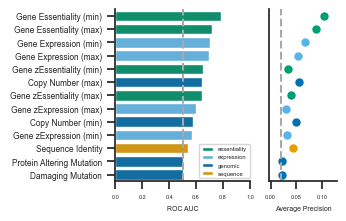

In [ ]:
def plot_roc_pr(pred_df):
    sns.set_theme(style="ticks")

    f, ax = plt.subplots(ncols=2, nrows=1, figsize=(3.5, 2.25), sharey=True, gridspec_kw={'width_ratios': [2, 1]})
    
    colors = ["#009E73", "#56B4E9", '#0072B2', "#E69F00"]
    #colors = ["#E64B35FF", "#4DBBD5FF", "#00A087FF", "#3C5488FF"]
    sns.set_palette(sns.color_palette(colors))

    sns.barplot(data=pred_df, x='mean_roc_auc', y='label', hue='category', palette=colors, saturation=0.8, dodge=False, ax=ax[0])
    ax[0].set_xlabel('ROC AUC', size=5) 
    ax[0].set_ylabel('')
    ax[0].set_xlim(0, 1)
    ax[0].tick_params('x', labelsize=4)
    ax[0].tick_params('y', labelsize=6)
    ax[0].axvline(x=0.5, linestyle='--', color='darkgrey')
    ax[0].legend(loc='lower right', fontsize=4.25, bbox_to_anchor=(1.02, 0))
    #ax[0].legend().remove()

    sns.pointplot(data=pred_df, x='avg_precision', y='label', hue='category', palette=colors,
                  dodge=False, markers='o', linestyles='none', errorbar=None, ax=ax[1])
    for line in plt.gca().lines:
        line.set_markersize(4)
    ax[1].set_xlabel('Average Precision', size=5) 
    ax[1].set_ylabel('')
    ax[1].set_xlim(pred_df['avg_precision'].min()-0.025, pred_df['avg_precision'].max()+0.025)
    
    # Remove y-ticks for ax[1]
    ax[1].tick_params('y', left=False, labelleft=False)
    ax[1].tick_params('x', labelsize=4)
    ax[1].axvline(x=no_skill, linestyle='--', color='darkgrey')
    ax[1].legend().remove()

    # Remove top and right borders
    sns.despine(ax=ax[0], top=True, right=True)
    sns.despine(ax=ax[1], top=True, right=True)

    plt.tight_layout(pad=0.7)
    #plt.show()
    plt.savefig(figure_path_a, bbox_inches="tight", dpi=300)

plot_roc_pr(pred_df)

### Box Plot

In [ ]:
box_feature = ['rMaxExp_A1A2', 'zMaxExp_A1A2', 'min_ranked_A1A2', 'z_min_ranked_A1A2', 'max_cn', 'min_sequence_identity']
box_labels = ['Gene Expression (max)', 'Gene zExpression (max)', 'Gene Essentiality (min)', 'Gene zEssentiality (min)', 'Copy Number', 'Sequence Identity']

display(dict(zip(box_feature, box_labels)))

In [ ]:
def draw_signif_line(ax, x0, x1, y, pval, hd=20):
    """Draws a significance line between two box plots."""
    h = y / hd
    if pval < 0.0001: 
        text = '$p$=%.1e' % pval
    else: 
        text = '$p$=%.4f' % pval
    ax.plot([x0, x0, x1, x1], [y + h, y + 2 * h, y + 2 * h, y + h], lw=0.8, c='#666')
    ax.text((x0 + x1) * .5, y + 2.5 * h, text, ha='center', va='bottom', color='#666', fontsize=5)


In [ ]:
def compute_upper_whisker(df, feature):
    """Computes the upper whisker of a box plot for a given feature."""
    Q1 = df[feature].quantile(q=0.25)
    Q3 = df[feature].quantile(q=0.75)
    IQR = Q3 - Q1
    return df[df[feature] <= (Q3 + 1.5 * IQR)][feature].max()

In [ ]:
def draw_cont_graph(df, feature, target_column, ax, label=None, fliers=True, show_points=True, draw_signif=True, hd=20):
    # Define the color palette based on feature names
    color_mapping = {
        'rMaxExp_A1A2': '#56B4E9',
        'zMaxExp_A1A2': '#56B4E9',
        'min_ranked_A1A2': '#009E73',
        'z_min_ranked_A1A2': '#009E73',
        'max_cn': '#0072B2',
        'min_sequence_identity': '#E69F00'
    }
    
    # Set the colors for False and True based on the feature
    true_color = color_mapping.get(feature, '#8491B4FF')  # default to original color if feature not in mapping
    my_pal = {False: "white", True: true_color}

    # Calculate the counts of SL and not_SL
    count_SL = (df[target_column] == True).sum()
    count_not_SL = (df[target_column] == False).sum()
    
    sns.despine(top=True, right=True, left=False, bottom=False)
    sns.boxplot(y=feature, x=target_column, hue=target_column, data=df, ax=ax, linewidth=0.8, saturation=0.8, 
                showfliers=False, showmeans=False, palette=my_pal, order=[False, True],  
                medianprops={'color':'black', 'linewidth':0.8},
                boxprops={'edgecolor':'black', 'alpha':0.85},)
    
    ax.set_ylabel(label if label else feature, fontsize=5.75)
    ax.set_xlabel('')
    ax.set_xticks([0, 1])
    ax.set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'])
    ax.tick_params(axis='y', rotation=0, labelsize=4)
    ax.legend().remove()

    #if show_points:
    #    sns.stripplot(y=feature, x=target_column, data=df, color='silver', ax=ax, alpha=0.7, size=2, zorder=0)
    #    ax.set_xlabel('')
    #    ax.legend().remove()

    if draw_signif:
        pval = stats.mannwhitneyu(df.loc[df[target_column] == True, feature], df.loc[df[target_column] == False, feature], alternative="two-sided")[1]
        upper_whisker = max(compute_upper_whisker(df.loc[df[target_column] == True], feature), compute_upper_whisker(df.loc[df[target_column] == False], feature))
        draw_signif_line(ax, 0, 1, upper_whisker + 0.05, pval, hd)


In [ ]:
count_SL = (df[target_column] == True).sum()
count_not_SL = (df[target_column] == False).sum()

f, ax = plt.subplots(3, 2, figsize=(3, 3.25), sharex=True)  
ax = ax.flatten()

for i in range(len(box_feature)):
    draw_cont_graph(df, box_feature[i], target_column, ax[i], label=box_labels[i])

# Remove x-tick labels from all subplots except for the second row (indices 2 and 3)
#for i in range(len(ax)):
#    if i != 3 and i != 4:
#        ax[i].set_xticklabels([])

# Set the x-tick labels for the subplot at index 3 (second row, second column)
ax[4].set_xticks([0, 1])
ax[4].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

ax[5].set_xticks([0, 1])
ax[5].set_xticklabels([f'not_SL \n(n={count_not_SL})', f'SL \n(n={count_SL})'], fontsize=6)

#f.delaxes(ax[-1])
plt.tight_layout(pad=0.7)
f.savefig(figure_path_b, bbox_inches="tight", dpi=300)
#plt.show()